# Zhihan Li Homework 1


1. Tokenization schemes of the dataset: <br />
1.1 Bag-of-words with English tokenizer 'en_core_web_sm'.<br />
1.2 Pre-processing by deleting line break '< br />' on Model 1.0. <br />
1.3 Removing web URLs using regular expression.


2. Model hyperparameters: Vary n for n-gram (n=1, 2, 3, 4), vocabulary size and embedding size. <br />
Model from 1.2 is the model for n=1.<br />
2.1 Bigram<br />
2.2 Trigram<br />
2.3 Quadrigram<br />


3. Optimization hyperparameters: <br />
3.1 Optimizer itself (SGD vs Adam)<br />
3.2 Change learning rate to be 0.05, 0.1. <br />
3.3 Use linear annealing of learning rate (learning rate is reduced linearly over the course of training). <br />

Please put this file in the aclImdb folder.

In [1]:
import random
from sklearn.utils import shuffle
import glob
import pandas as pd
import re

Import and preprocessing data.

In [3]:
test_neg_files = glob.glob("test/neg/*.txt")
test_pos_files = glob.glob("test/pos/*.txt")
test_un_files = glob.glob("test/unsup/*.txt")    

train_neg_files = glob.glob("train/neg/*.txt")
train_pos_files = glob.glob("train/pos/*.txt")
train_un_files = glob.glob("train/unsup/*.txt")

# read list of files to list of strings 
def to_str(list, num):
    data = []
    target = []
    for file in list:
        with open(file, 'r') as myfile:
            text = myfile.read()
            # for 1.3
            text = re.sub(r'^https?:\/\/.*[\r\n]*\/', '', text, flags=re.MULTILINE) 
            # for 1.2
            text = text.replace('<br />','')
            text = text.replace('(',' ')
            text = text.replace(')',' ')
            # for 1.1
            data.append(text) 
            # data.append(myfile.read()) for 1.1
    target = [num] * len(data)
    df = pd.DataFrame({'data': data, 'target': target})
    return df

# 0 is neg, 1 is pos, 2 is unsup
train_neg = to_str(train_neg_files,0)
train_pos = to_str(train_pos_files,1)
train_un = to_str(train_un_files,2)
test_neg = to_str(test_neg_files,0)
test_pos = to_str(test_pos_files,1)
test_un = to_str(test_un_files,2)

# 75000 in total
train_val = pd.concat([train_neg, train_pos, train_un], ignore_index=True)
train_val = train_val.sample(frac=1).reset_index(drop=True)

train_split = 55000
train_raw = train_val[:train_split]
val_raw = train_val[train_split:]

test_raw = pd.concat([test_neg, test_pos, test_un], ignore_index=True)
test_raw = test_raw.sample(frac=1).reset_index(drop=True)

In [4]:
# train = train_raw[:1000]
# val = val_raw[:250]
# test = test_raw[:200]
train = train_raw
val = val_raw
test = test_raw

In [5]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation 
def tokenize_grams(sample):
    list2 = []
    list3 = []
    list4 = []
    a = tokenize(sample)
    list1 = a
    for j in range(len(a)-3):
            list2.append(a[j] + " " +a[j+1])
            list3.append(a[j] + " " +a[j+1]+" "+ a[j+2])
            list4.append(a[j]+" "+a[j+1]+" "+ a[j+2]+" "+a[j+3])
    list2.append(a[len(a)-2]+" "+ a[len(a)-1])
    list2.append(a[len(a)-3]+" "+a[len(a)-2])
    list3.append(a[len(a)-3]+" "+a[len(a)-2]+" "+a[len(a)-1])
    return list1, list2, list3, list4
    
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]

Tokenize train/val/test datasets

In [4]:
# This is the code cell that tokenizes train/val/test datasets
# However it takes about 15-20 minutes to run it
# For convinience we have provided the preprocessed datasets
# Please see the next code cell

import pickle as pkl

def tokenize_dataset(dataset):
    token_dataset1 = []
    token_dataset2 = []
    token_dataset3 = []
    token_dataset4 = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens1= [] 
    all_tokens2= []
    all_tokens3= [] 
    all_tokens4= [] 

    for sample in dataset:
        
#         sample2 = get_ngram(sample,i)
#         tokens = lower_case_remove_punc(sample_2)
#         token_dataset[i].append(tokens)
       
        # tokens is a list of words       
        tokens1,tokens2,tokens3,tokens4 = tokenize_grams(sample)
        token_dataset1.append(tokens1)
        token_dataset2.append(tokens2)
        token_dataset3.append(tokens3)
        token_dataset4.append(tokens4)
        
        all_tokens1 += tokens1
        all_tokens2 += tokens2
        all_tokens3 += tokens3
        all_tokens4 += tokens4

    return token_dataset1,token_dataset2,token_dataset3,token_dataset4, all_tokens1,all_tokens2,all_tokens3,all_tokens4

# val set tokens
print ("Tokenizing val data")
vds1,vds2,vds3,vds4, va1,va2,va3,va4 = tokenize_dataset(val['data'].tolist())
print ("Tokenizing test data")
tds1,tds2,tds3,tds4, ta1,ta2,ta3,ta4 = tokenize_dataset(test['data'].tolist())
print ("Tokenizing train data")
trds1,trds2, trds3, trds4, tra1,tra2,tra3,tra4 = tokenize_dataset(train['data'].tolist())

Specify the number of grams we need: 

In [9]:
n=1
if n==1:
    val_data_tokens, _ = vds1, va1
    test_data_tokens, _  = tds1, ta1
    train_data_tokens, all_train_tokens = trds1, tra1
if n==2:
    val_data_tokens, _ = vds2, va2
    test_data_tokens, _  = tds2, ta2
    train_data_tokens, all_train_tokens = trds2, tra2
if n==3:
    val_data_tokens, _ = vds3, va3
    test_data_tokens, _  = tds3, ta3
    train_data_tokens, all_train_tokens = trds3, tra3
if n==4:
    val_data_tokens, _ = vds4, va4
    test_data_tokens, _  = tds4, ta4
    train_data_tokens, all_train_tokens = trds4, tra4

# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))
# pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

Create the vocabulary of most common 10,000 tokens in the training set.

In [21]:
from collections import Counter

# max_vocab_size = 5000
max_vocab_size = 500
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    # dont know how it works
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [6]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Create PyTorch DataLoader

In [23]:
MAX_SENTENCE_LENGTH = 100

import numpy as np
import torch
from torch.utils.data import Dataset

class FeedsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of feedsgroup tokens 
        @param target_list: list of feedsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]

        return [token_idx, len(token_idx), label]

def feedsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


BATCH_SIZE = 32
train_dataset = FeedsGroupDataset(train_data_indices, train['target'].tolist())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=feedsgroup_collate_func,
                                           shuffle=True)

val_dataset = FeedsGroupDataset(val_data_indices, val['target'].tolist())
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=feedsgroup_collate_func,
                                           shuffle=True)

test_dataset = FeedsGroupDataset(test_data_indices, test['target'].tolist())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=feedsgroup_collate_func,
                                           shuffle=False)

# for i, (data, lengths, labels) in enumerate(train_loader):
#    print (data)
#    print (type(labels[0]))
#    break

Define Bag-of-n-grams model in PyTorch

In [24]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,3)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

Train the model and test on it. Here we have the option to modify the learning rate and optimizer we are going to use.

In [7]:
learning_rate = 0.01
# learning_rates = 0.2
# learning_rate = 0.05

num_epochs = 10 # number epoch to train
decay = learning_rate / num_epochs

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
# using SGD
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# using Adam
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        # counts how many of them are correct 
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

for epoch in range(num_epochs):
    # linear annealing of learning rate
    learning_rate = learning_rate * 1/(1 + decay * epoch)
    print(learning_rate)
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        # forward propagation
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
#         if i > 0 and i % 100 == 0:
#             # validate
    val_acc = test_model(val_loader, model)
    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

In [14]:
print("After training for {} epochs".format(num_epochs))
print("Val Acc {}".format(test_model(val_loader, model)))
print("Test Acc {}".format(test_model(test_loader, model)))

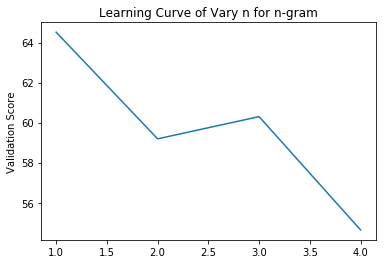

In [4]:
import matplotlib.pyplot as plt
# using Adam, max_vocab_size = 10000, emb_dim = 100, learning rate = linear annealing
val_n = [64.515,59.19,60.3,54.64]
n = [1,2,3,4]
plt.plot(n, val_n)
plt.title('Learning Curve of Vary n for n-gram')
plt.ylabel('Validation Score')
plt.show()

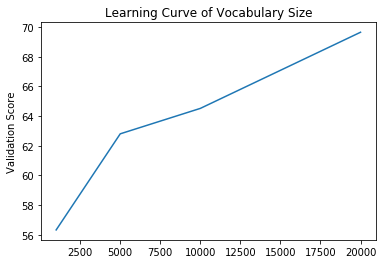

In [13]:
# Tokenization schemes
# Vocabulary size
val_vocab = [ 56.32,62.8,64.515, 69.65]
vocab_size = [1000, 5000, 10000, 20000]
plt.plot(vocab_size, val_vocab)
plt.title('Learning Curve of Vocabulary Size')
plt.ylabel('Validation Score')
plt.show()

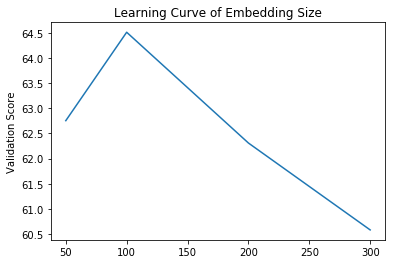

In [12]:
# Embedding size
val_emb = [ 62.755,64.515,62.31,60.58]
emb_size = [50,100,200,300]
plt.plot(emb_size, val_emb)
plt.title('Learning Curve of Embedding Size')
plt.ylabel('Validation Score')
plt.show()

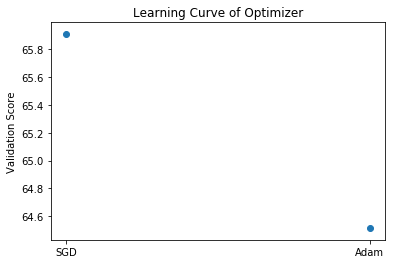

In [66]:
# Optimizer (SGD v.s. Adam)
val_opt = [65.91, 64.515]
opts = ["SGD","Adam"]
plt.scatter(opts, val_opt)
plt.title('Learning Curve of Optimizer')
plt.ylabel('Validation Score')
plt.show()

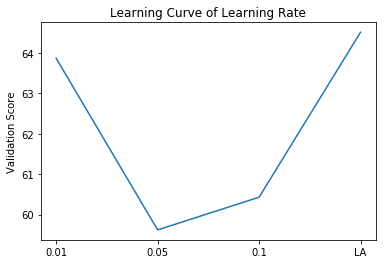

In [3]:
# learning rate
val_lr = [63.87,59.62,60.43,64.515]
lr_size = [0.01,0.05,0.1,'LA']
plt.plot(lr_size, val_lr)
plt.title('Learning Curve of Learning Rate')
plt.ylabel('Validation Score')
plt.show()